<a href="https://colab.research.google.com/github/rainmaker29/Expression-detection/blob/master/feripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fer_drive as utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from IPython.display import SVG,Image
# from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0-rc3


# Plot examples

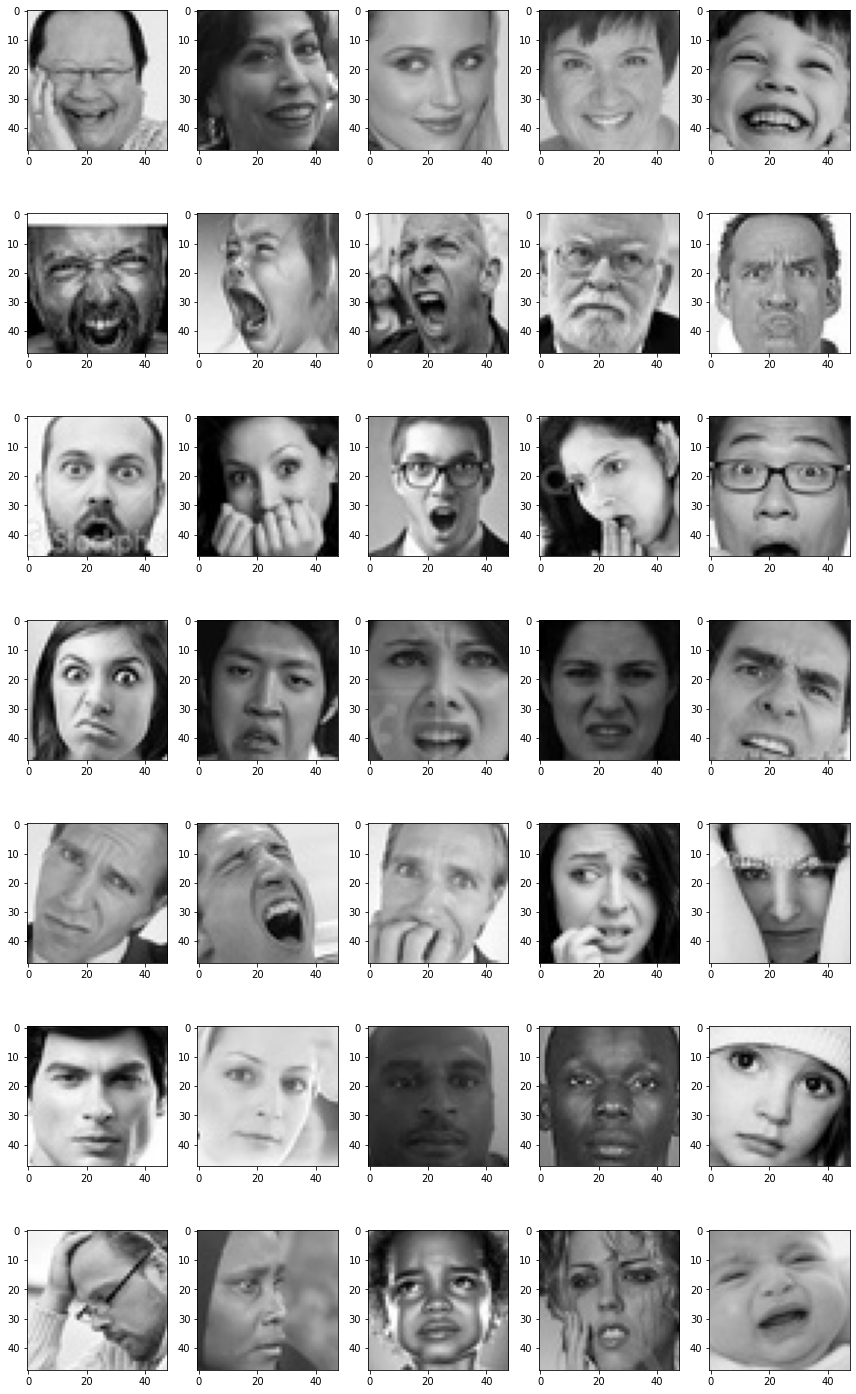

In [0]:
utils.plot_example_images(plt).show()

In [0]:
for expression in os.listdir("/content/drive/My Drive/Face_rec/train_zipped/train"):
  print(str(len(os.listdir("/content/drive/My Drive/Face_rec/train_zipped/train/"+expression)))+" "+expression
        +" images")

7206 happy images
3326 angry images
3142 surprise images
446 disgust images
4097 fear images
4965 neutral images
2486 sad images


# Training and validation batches

In [0]:
img_size = 48
batch_size=64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("/content/drive/My Drive/Face_rec/train_zipped/train",
                                              target_size=(img_size,img_size),
                                              color_mode="grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle=True
                                                   )
datagen_test = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_test.flow_from_directory("/content/drive/My Drive/Face_rec/test_zipped/test",
                                              target_size=(img_size,img_size),
                                              color_mode="grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle=False
                                              
                                              )

Found 25668 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Building CNN

In [0]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

# Training

In [0]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [0]:
epochs = 100
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reducing learning rate as the training proceeds
reduce_lr = ReduceLROnPlateau(monitor='loss',factor=0.1,patience=5,min_lr=0.00001,mode="auto")

#Saving the model 
checkpoint = ModelCheckpoint("model_weights.h5",monitor='accuracy',
                             save_weights_only=True,
                             mode="max",
                             verbose=1
                             )

callbacks = [checkpoint,reduce_lr]

history = model.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_generator=validation_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks)


Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.8848 - accuracy: 0.6688
Epoch 00001: saving model to model_weights.h5
401/401 [==============================] - 39s 97ms/step - loss: 0.8848 - accuracy: 0.6688 - lr: 5.0000e-04
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.8529 - accuracy: 0.6825
Epoch 00002: saving model to model_weights.h5
401/401 [==============================] - 39s 96ms/step - loss: 0.8529 - accuracy: 0.6825 - lr: 5.0000e-04
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.8413 - accuracy: 0.6863
Epoch 00003: saving model to model_weights.h5
401/401 [==============================] - 39s 96ms/step - loss: 0.8413 - accuracy: 0.6863 - lr: 5.0000e-04
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.8127 - accuracy: 0.6972
Epoch 00004: saving model to model_weights.h5
401/401 [==============================] - 39s 97ms/step - loss: 0.8127 - accuracy: 0.6972 - lr: 5.0000e

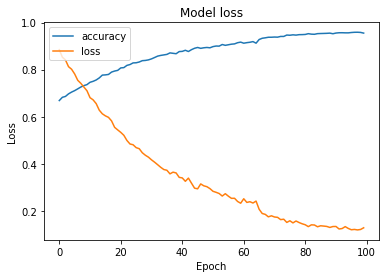

In [0]:

plt.plot(history.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')



# Plot training & validation loss values
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)